[Building makemore Part 5: Building a WaveNet](https://youtu.be/t3YJ5hKiMQ0?si=Phthum_6_Yq9mrpc)

https://github.com/karpathy/makemore

https://github.com/karpathy/nn-zero-to-hero/blob/master/lectures/makemore/makemore_part5_cnn1.ipynb

https://colab.research.google.com/drive/1CXVEmCO_7r7WYZGb5qnjfyxTvQa13g5X?usp=sharing

[WaveNet: A Generative Model for Raw Audio](https://arxiv.org/abs/1609.03499)

[A Neural Probabilistic Language Model](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf)

[WaveNet: A generative model for raw audio](https://deepmind.google/discover/blog/wavenet-a-generative-model-for-raw-audio/)

In [113]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [114]:
# download the names.txt file from github
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

--2025-07-23 20:15:44--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt.3’

names.txt.3         100%[===================>] 222.80K  --.-KB/s    in 0.04s   

2025-07-23 20:15:44 (5.97 MB/s) - ‘names.txt.3’ saved [228145/228145]



In [115]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [116]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [117]:
# shuffle up the words
import random
random.seed(42)
random.shuffle(words)

In [118]:
# build the dataset
block_size = 8 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [119]:
for x,y in zip(Xtr[:20], Ytr[:20]):
  print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> y
.......y --> u
......yu --> h
.....yuh --> e
....yuhe --> n
...yuhen --> g
..yuheng --> .
........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .
........ --> x
.......x --> a
......xa --> v
.....xav --> i
....xavi --> e


In [120]:
# Near copy paste of the layers we have developed in Part 3

# -----------------------------------------------------------------------------------------------
class Linear:

  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # note: kaiming init
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

# -----------------------------------------------------------------------------------------------
class BatchNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    # calculate the forward pass
    # this is a fix for BatchNorm--------------------------
    if self.training:
      if x.ndim == 2:
        dim = 0
      elif x.ndim == 3:
        dim = (0,1)
      # this is a fix for BatchNorm--------------------------
      xmean = x.mean(dim, keepdim=True) # batch mean
      xvar = x.var(dim, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

# -----------------------------------------------------------------------------------------------
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

# add new layers to simplify code
# was C
class Embedding:
  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim))

  def __call__(self, IX):
    self.out = self.weight[IX]
    return self.out

  def parameters(self):
    return [self.weight]

# was x
# class Flatten:
#   # wavenet --------------------------------------
#   def __init__(self, n):
#     self.n = n
#   # wavenet --------------------------------------

#   def __call__(self, x):
#     self.out = x.view(x.shape[0], -1)
#     return self.out

#   def parameters(self):
#     return []

class FlattenConsecutive:
  # wavenet --------------------------------------
  def __init__(self, n):
    self.n = n
  # wavenet --------------------------------------

  def __call__(self, x):
    B, T, C = x.shape
    x = x.view(B, T//self.n, C*self.n)
    if x.shape[1] == 1:
      x = x.squeeze(1)
    self.out = x
    return self.out

  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
class Sequential:
  def __init__(self, layers):
    self.layers = layers

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out

  def parameters(self):
    # get parameters of all layers and stretch them out into one list
    return [p for layer in self.layers for p in layer.parameters()]

In [121]:
torch.manual_seed(42); # seed rng for reproducibility

In [122]:
# original network
n_embd = 24 # the dimensionality of the character embedding vectors
n_hidden = 128 # the number of neurons in the hidden layer of the MLP

# replace C with Embedding and Flatten layers
# C = torch.randn((vocab_size, n_embd))
# layers = [
#   Embedding(vocab_size, n_embd),
#   Flatten(),
#   Linear(n_embd * block_size, n_hidden, bias=False),
#   BatchNorm1d(n_hidden),
#   Tanh(),
#   Linear(n_hidden, vocab_size),
# ]
# continue to simplify, introduce Containers and Sequential
model = Sequential([
  Embedding(vocab_size, n_embd),
  FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size),
])

# parameter init
with torch.no_grad():
  model.layers[-1].weight *= 0.1 # last layer make less confident

# parameters = [C] + [p for layer in layers for p in layer.parameters()]
# parameters = [p for layer in layers for p in layer.parameters()]
parameters = model.parameters()

print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

76579


In [123]:
# before implementing WaveNet let's look to the shapes of the data
ix = torch.randint(0, Xtr.shape[0], (4,)) # let's look to a batch of 4 examples
Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
logits = model(Xb)
print(logits.shape)
Xb

torch.Size([4, 27])


tensor([[ 0,  0,  0,  0,  0,  0, 12, 15],
        [ 0,  0,  0,  0, 16, 15, 18, 20],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0, 12,  1, 25,  1, 14, 14]])

In [124]:
# layer inspector :)
for layer in model.layers:
  print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (4, 8, 24)
FlattenConsecutive : (4, 4, 48)
Linear : (4, 4, 128)
BatchNorm1d : (4, 4, 128)
Tanh : (4, 4, 128)
FlattenConsecutive : (4, 2, 256)
Linear : (4, 2, 128)
BatchNorm1d : (4, 2, 128)
Tanh : (4, 2, 128)
FlattenConsecutive : (4, 256)
Linear : (4, 128)
BatchNorm1d : (4, 128)
Tanh : (4, 128)
Linear : (4, 27)


In [125]:
# the code below is our BatchNorm
# and currently we have a bug with it
# BatchNorm now runs in parallel 4 times 68, instead of 68
e = torch.randn(32, 4, 68)
# emean = e.mean(0, keepdim=True) # 1, 4, 68
# we can execute mean not only a dimension, but also on tuple
emean = e.mean((0,1), keepdim=True) # 1, 1, 68
# evar = e.var(0, keepdim=True) # 1, 4, 68
evar = e.var((0,1), keepdim=True) # 1, 1, 68
ehat = (e - emean) / torch.sqrt(evar + 1e-5) # 32, 4, 68
print(ehat.shape)
print(emean.shape)
print(evar.shape)
print(model.layers[3].running_mean.shape)

torch.Size([32, 4, 68])
torch.Size([1, 1, 68])
torch.Size([1, 1, 68])
torch.Size([1, 1, 128])


In [126]:
model.layers[0].out.shape # output of Embedding layer
# for each char we have 10 dimensial vector

torch.Size([4, 8, 24])

In [127]:
model.layers[1].out.shape # output of Flatten layer
# works as concatenation operation of Embedding layer 4,8,10 to 4,80

torch.Size([4, 4, 48])

In [128]:
model.layers[2].out.shape # output of Linear layer

torch.Size([4, 4, 128])

In [129]:
# example of what happens in Linear layer
# matrix multiplication happens on the last dimension and the first are unchanged!
# (torch.randn(4, 5, 2, 80) @ torch.randn(80, 200) + torch.randn(200)).shape
# we want only 2 chars to come to the 1st layer and fused
# 1st 4 - is the 1st batch dimension
# 2nd 4 - is the 2nd batch dimension
(torch.randn(4, 4, 20) @ torch.randn(20, 200) + torch.randn(200)).shape

torch.Size([4, 4, 200])

In [130]:
list(range(10))[::2]

[0, 2, 4, 6, 8]

In [131]:
list(range(10))[1::2]

[1, 3, 5, 7, 9]

In [132]:
e = torch.randn(4, 8, 10) # we want 4, 4, 20
# this is python way, but as you see in the cell below it is possible to achieve the same result,
# but with no cost by using view
explicit = torch.cat([e[:, ::2, :], e[:, 1::2, :]], dim=2) # only even and odd chars for second dimension
explicit.shape

torch.Size([4, 4, 20])

In [133]:
(e.view(4, 4, 20) == explicit).all()

tensor(True)

In [134]:
# for wavenet we want
# (1,2) (3,4) (5,6) (7,8)
# all these groups we want to process in parallel

In [135]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  # we want to simplify this code, and make emb and x in layers!
  # emb = C[Xb] # embed chars into vectors
  # x = emb.view(emb.shape[0], -1) # flatten to 2D, concatenate the vectors

  # x = Xb
  # for layer in layers:
  #   x = layer(x)
  # loss = F.cross_entropy(x, Yb) # loss function

  # and with Sequential it is simplifies again
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update: simple SGD
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

  # break

      0/ 200000: 3.2970
  10000/ 200000: 2.0468
  20000/ 200000: 2.3454
  30000/ 200000: 2.0426
  40000/ 200000: 1.9818
  50000/ 200000: 2.1406
  60000/ 200000: 1.9171
  70000/ 200000: 1.7059
  80000/ 200000: 1.7981
  90000/ 200000: 1.9324
 100000/ 200000: 1.6421
 110000/ 200000: 2.0126
 120000/ 200000: 1.6993
 130000/ 200000: 1.8496
 140000/ 200000: 1.7546
 150000/ 200000: 1.4790
 160000/ 200000: 1.7791
 170000/ 200000: 1.7836
 180000/ 200000: 1.7374
 190000/ 200000: 2.0255


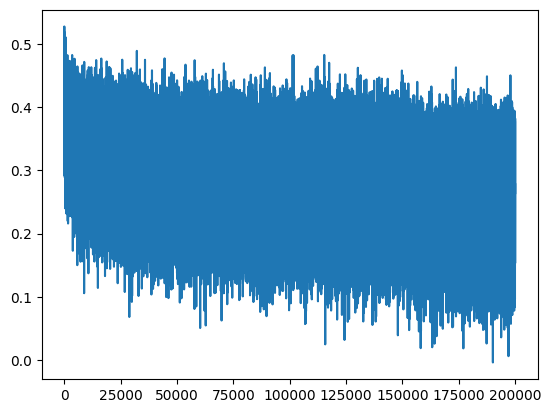

In [136]:
# the plot initially looks terrible, because we have just 32 values and it is on or off
plt.plot(lossi)

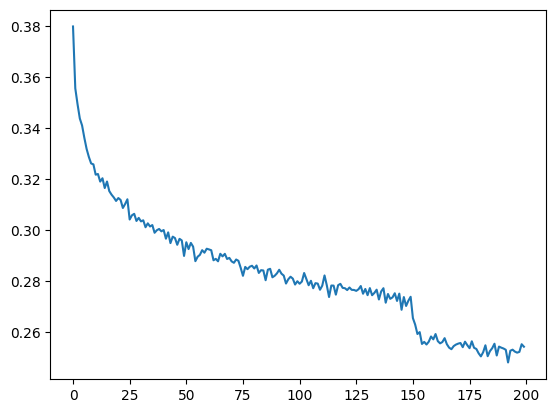

In [137]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [138]:
# put layers into eval mode (needed for batchnorm especially)
for layer in model.layers:
  layer.training = False

In [139]:
# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  # simplification due to Sequential
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

  # emb = C[x] # N, block_size, n_embd
  # x = emb.view(emb.shape[0], -1) # flatten to 2D
  # for layer in layers:
  #   x = layer(x)
  # loss = F.cross_entropy(x, y)
  # print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.7631216049194336
val 1.9911118745803833


### performance log

- original (3 character context + 200 hidden neurons, 12K params): train 2.058, val 2.105
- context: 3 -> 8 (22K params): train 1.918, val 2.027
- flat -> hierarchical (22K params): train 1.941, val 2.029
- fix bug in batchnorm: train 1.912, val 2.022
- scale up the network: n_embd 24, n_hidden 128 (76K params): train 1.769, val 1.993

In [140]:
# sample from the model
for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      logits = model(torch.tensor([context]))

      # Sequential simplification
      # emb = C[torch.tensor([context])] # (1,block_size,d)
      # x = emb.view(emb.shape[0], -1) # flatten to 2D
      # for layer in layers:
      #   x = layer(x)
      # logits = x
      probs = F.softmax(logits, dim=1)

      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1).item()

      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break

    print(''.join(itos[i] for i in out)) # decode and print the generated word

taviano.
eyton.
samiya.
dominic.
rass.
jerman.
starlette.
shadya.
keira.
jaylenn.
adone.
enona.
eoluwa.
nohta.
emvi.
faalylah.
marikat.
eastin.
kaedi.
airel.


### Next time:
Why convolutions? Brief preview/hint

In [141]:
for x,y in zip(Xtr[7:15], Ytr[7:15]):
  print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

In [142]:
# forward a single example:
logits = model(Xtr[[7]])
logits.shape

torch.Size([1, 27])

In [143]:
# forward all of them
logits = torch.zeros(8, 27)
for i in range(8):
  logits[i] = model(Xtr[[7+i]])
logits.shape

torch.Size([8, 27])

In [144]:
# convolution is a "for loop"
# allows us to forward Linear layers efficiently over space